In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.2.2


In [2]:
from torch_geometric.datasets import Reddit2
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import subgraph

dataset = Reddit2(root='data/Reddit', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


Dataset: Reddit2():
Number of graphs: 1
Number of features: 602
Number of classes: 41

Data(x=[232965, 602], edge_index=[2, 23213838], y=[232965], train_mask=[232965], val_mask=[232965], test_mask=[232965])
Number of nodes: 232965
Number of edges: 23213838
Average node degree: 99.65


## Manually wrangling data

In [3]:
torch.bincount(data.y)

tensor([13101,  3550,  3302, 15181,  2322,  3597,  3952,  2138, 11187,  2246,
         4928,  2964,  1696,  2731,  4854, 28272,  1003,  2639, 13999, 10308,
         1596,  4066,  8222, 12146,   328,  1659,  4239,  5962,  4673,  5101,
         2846,  4570,  1575,  4960,  3429,  4202,  4180,  4233, 12797,  3099,
         5112])

In [4]:
node_indices = torch.where(condition=((data.y == 4) |
                                      # (data.y == 5) |
                                      (data.y == 6)) == True)[0]
node_indices

tensor([    10,     12,     28,  ..., 232936, 232949, 232957])

In [5]:
edge_subset, edge_attr = subgraph(node_indices, data.edge_index, relabel_nodes=True)
print(edge_subset)
print(edge_subset.shape)

tensor([[   0,    0,    0,  ..., 6273, 6273, 6273],
        [ 118,  132,  276,  ..., 6056, 6215, 6253]])
torch.Size([2, 355634])


In [6]:
node_subset = data.x[node_indices]
data_x = node_subset
data_y = data.y[node_indices]
data_y[data_y == 4] = 0
data_y[data_y == 6] = 1
print(data_x.shape)
print(data_y.shape)

torch.Size([6274, 602])
torch.Size([6274])


In [7]:
data_y

tensor([1, 1, 0,  ..., 0, 1, 0])

In [8]:
alpha = 0.05

mask = torch.torch.rand((node_subset.shape[0]))
train_mask = mask > (1-alpha)
print(sum(train_mask))

test_mask = mask < alpha
print(sum(test_mask))

tensor(275)
tensor(311)


## MLP Model

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=602, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=41, bias=True)
)


In [10]:

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():

      model.train()
      optimizer.zero_grad()
      out = model(data_x)  # Single forward pass.
      loss = criterion(out[train_mask], data_y[train_mask])  # Compute loss
      loss.backward()  # Derive grads
      optimizer.step()  # Update params
      return loss

def test():
      model.eval()
      data_x = node_subset
      out = model(data_x)
      pred = out.argmax(dim=1)
      test_correct = pred[test_mask] == data_y[test_mask]
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Ratio of correct preds
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 3.5348
Epoch: 002, Loss: 3.4948
Epoch: 003, Loss: 3.4608
Epoch: 004, Loss: 3.4238
Epoch: 005, Loss: 3.3853
Epoch: 006, Loss: 3.3453
Epoch: 007, Loss: 3.2964
Epoch: 008, Loss: 3.2533
Epoch: 009, Loss: 3.2004
Epoch: 010, Loss: 3.1304
Epoch: 011, Loss: 3.0867
Epoch: 012, Loss: 3.0128
Epoch: 013, Loss: 2.9579
Epoch: 014, Loss: 2.8680
Epoch: 015, Loss: 2.7998
Epoch: 016, Loss: 2.7173
Epoch: 017, Loss: 2.6379
Epoch: 018, Loss: 2.5632
Epoch: 019, Loss: 2.4919
Epoch: 020, Loss: 2.4234
Epoch: 021, Loss: 2.3071
Epoch: 022, Loss: 2.2090
Epoch: 023, Loss: 2.1469
Epoch: 024, Loss: 2.0235
Epoch: 025, Loss: 1.9161
Epoch: 026, Loss: 1.8503
Epoch: 027, Loss: 1.7438
Epoch: 028, Loss: 1.6582
Epoch: 029, Loss: 1.5880
Epoch: 030, Loss: 1.5388
Epoch: 031, Loss: 1.4573
Epoch: 032, Loss: 1.4147
Epoch: 033, Loss: 1.2890
Epoch: 034, Loss: 1.2836
Epoch: 035, Loss: 1.2378
Epoch: 036, Loss: 1.1910
Epoch: 037, Loss: 1.2042
Epoch: 038, Loss: 1.1534
Epoch: 039, Loss: 1.1173
Epoch: 040, Loss: 1.0413


In [11]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6109


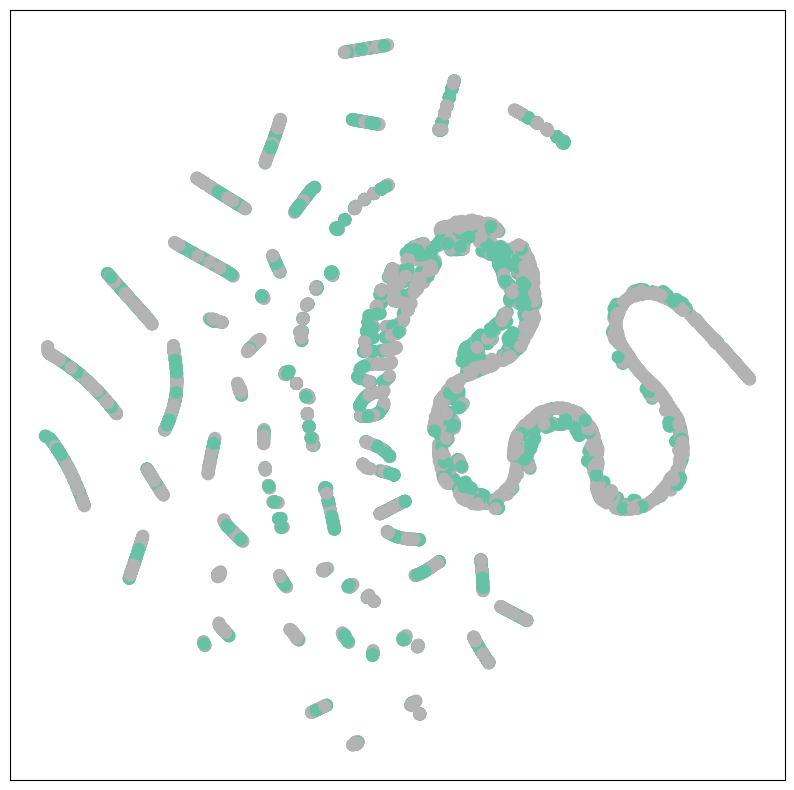

In [12]:
model.eval()
out = model(data_x)
visualize(out, color=data_y)

## GCN Model

In [13]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.num_classes = torch.unique(data_y).shape[0]
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, self.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(602, 16)
  (conv2): GCNConv(16, 2)
)


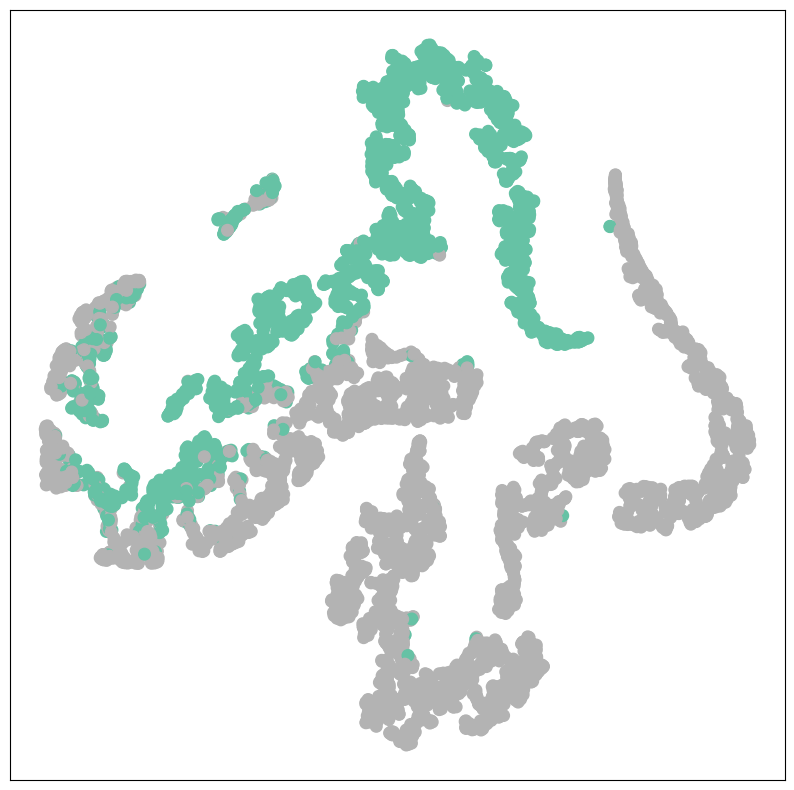

In [14]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data_x, edge_subset)
visualize(out, color=data_y)

In [15]:

model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data_x, edge_subset)  # Single forward pass.
      loss = criterion(out[train_mask], data_y[train_mask])  # Compute loss
      loss.backward()  # Derive grads
      optimizer.step()  # Update params
      return loss

def test():
      model.eval()
      out = model(data_x, edge_subset)
      pred = out.argmax(dim=1)
      test_correct = pred[test_mask] == data_y[test_mask]
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Ratio of correct preds
      return test_acc


for epoch in range(1, 51):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.6948
Epoch: 002, Loss: 0.6821
Epoch: 003, Loss: 0.6740
Epoch: 004, Loss: 0.6660
Epoch: 005, Loss: 0.6589
Epoch: 006, Loss: 0.6555
Epoch: 007, Loss: 0.6538
Epoch: 008, Loss: 0.6497
Epoch: 009, Loss: 0.6464
Epoch: 010, Loss: 0.6470
Epoch: 011, Loss: 0.6422
Epoch: 012, Loss: 0.6373
Epoch: 013, Loss: 0.6340
Epoch: 014, Loss: 0.6272
Epoch: 015, Loss: 0.6249
Epoch: 016, Loss: 0.6221
Epoch: 017, Loss: 0.6142
Epoch: 018, Loss: 0.6067
Epoch: 019, Loss: 0.6096
Epoch: 020, Loss: 0.6015
Epoch: 021, Loss: 0.5982
Epoch: 022, Loss: 0.5867
Epoch: 023, Loss: 0.5795
Epoch: 024, Loss: 0.5776
Epoch: 025, Loss: 0.5704
Epoch: 026, Loss: 0.5670
Epoch: 027, Loss: 0.5594
Epoch: 028, Loss: 0.5540
Epoch: 029, Loss: 0.5447
Epoch: 030, Loss: 0.5333
Epoch: 031, Loss: 0.5285
Epoch: 032, Loss: 0.5160
Epoch: 033, Loss: 0.5110
Epoch: 034, Loss: 0.4991
Epoch: 035, Loss: 0.4918
Epoch: 036, Loss: 0.4857
Epoch: 037, Loss: 0.4734
Epoch: 038, Loss: 0.4731
Epoch: 039, Loss: 0.4576
Epoch: 040, Loss: 0.4513


In [16]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9711


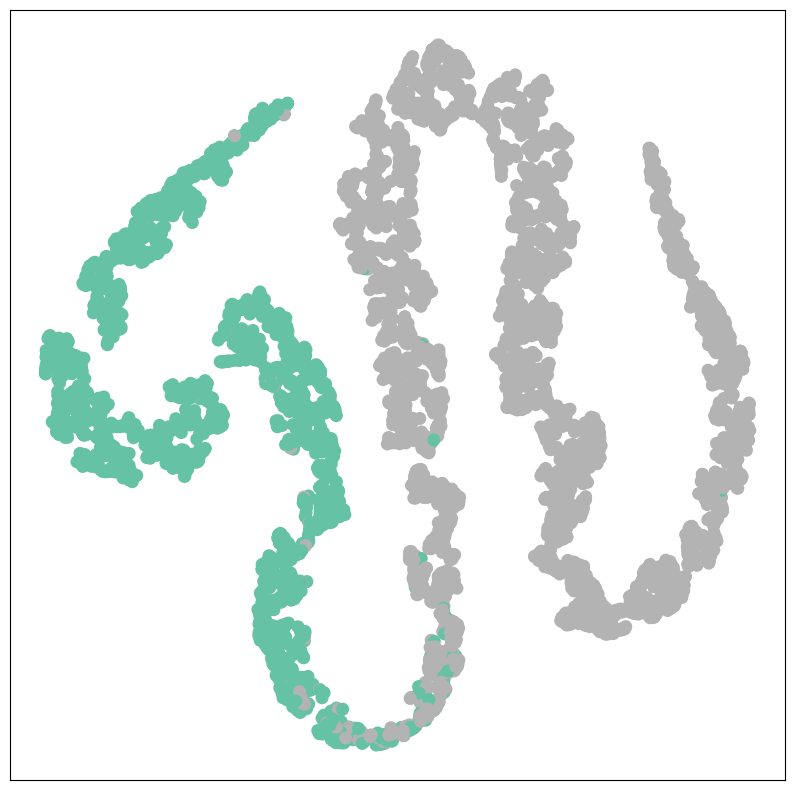

In [17]:
model.eval()
out = model(data_x, edge_subset)
visualize(out, color=data_y)

## GAT Model

In [26]:

import torch
import torch.nn.functional as F

from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GAT(in_channels = dataset.num_features,
            hidden_channels = 32,
            out_channels = 2,
            heads = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_x, edge_subset)
    loss = criterion(out[train_mask], data_y[train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data_x, edge_subset).argmax(dim=1)

    test_correct = pred[test_mask] == data_y[test_mask]
    test_acc = int(test_correct.sum()) / int(test_mask.sum())
    return test_acc

for epoch in range(1, 21):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 0.6878
Epoch: 002, Loss: 0.6754
Epoch: 003, Loss: 0.6643
Epoch: 004, Loss: 0.6532
Epoch: 005, Loss: 0.6454
Epoch: 006, Loss: 0.6351
Epoch: 007, Loss: 0.6305
Epoch: 008, Loss: 0.6406
Epoch: 009, Loss: 0.6342
Epoch: 010, Loss: 0.6183
Epoch: 011, Loss: 0.6184
Epoch: 012, Loss: 0.5926
Epoch: 013, Loss: 0.5955
Epoch: 014, Loss: 0.6050
Epoch: 015, Loss: 0.5788
Epoch: 016, Loss: 0.5582
Epoch: 017, Loss: 0.5468
Epoch: 018, Loss: 0.5659
Epoch: 019, Loss: 0.5248
Epoch: 020, Loss: 0.5537


In [27]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9711


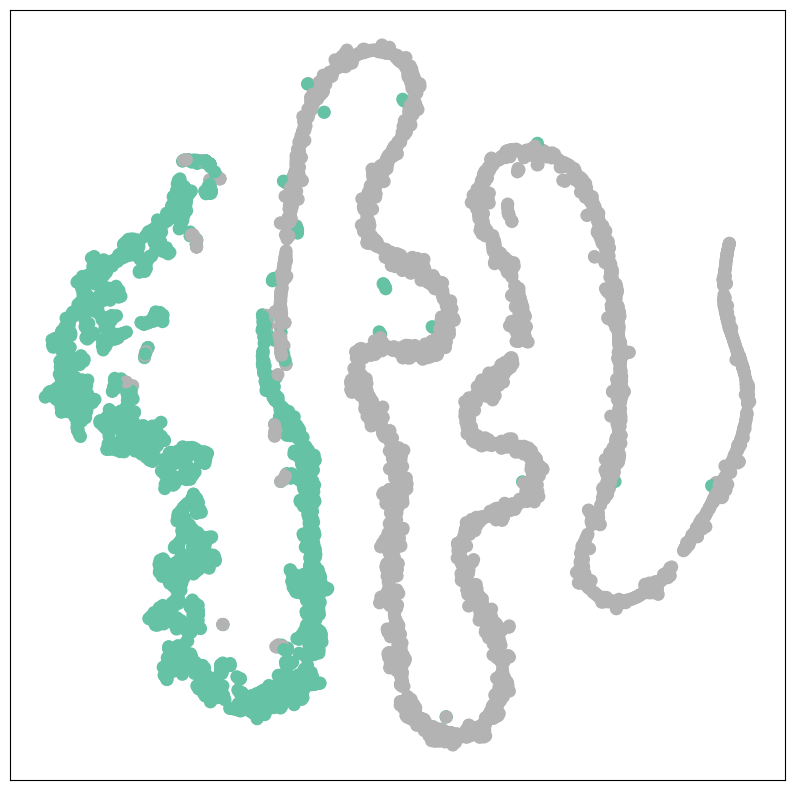

In [28]:
model.eval()
out = model(data_x, edge_subset)
visualize(out, color=data_y)

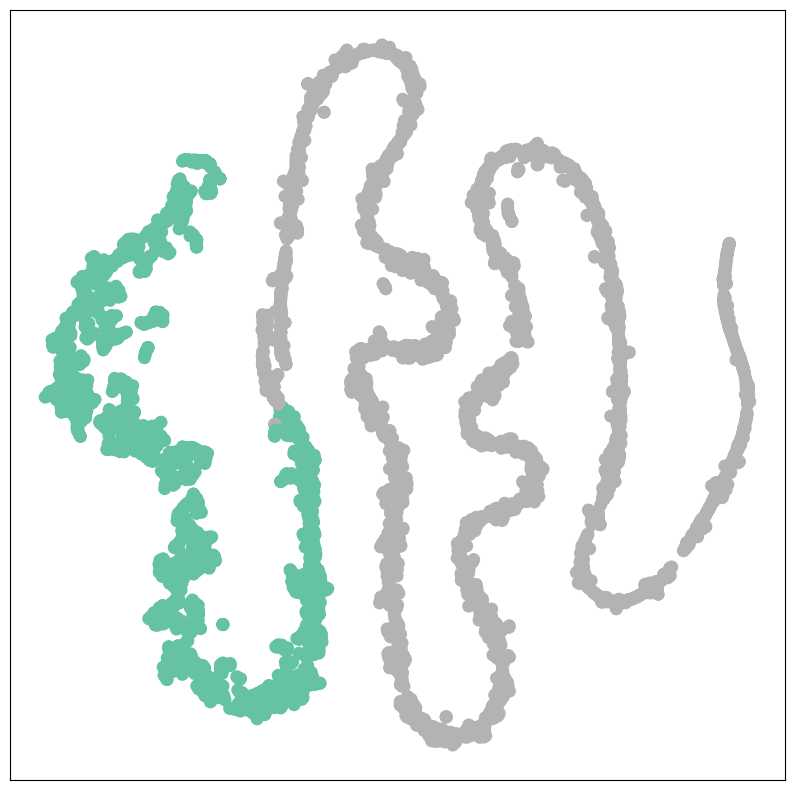

In [29]:
visualize(out, color=out.argmax(dim=1))